### Linear Regression Modeling of California Home Prices
Last updated: Feb 4, 2018


## Instructions
In this project, we will work with the California Home Price dataset.  We will train a regression model to predict median home prices.  

First, we will go through this example.  Then you will make modifications and run the code, collecting results.

Learning Objectives
Students will gain additional expertise in the following:

RDDs, DataFrames, data preprocessing, feature engineering, model training, model evalulation

### Data Source
StatLib---Datasets Archive  
http://lib.stat.cmu.edu/datasets/

houses.zip
These spatial data contain 20,640 observations on housing prices with 9 economic covariates. It appeared in Pace and Barry (1997), "Sparse Spatial Autoregressions", Statistics and Probability Letters. Submitted by Kelley Pace (kpace@unix1.sncc.lsu.edu). [9/Nov/99] (536 kbytes)



Data Description
This tutorial makes use of the California Housing data set. It appeared in a 1997 paper titled Sparse Spatial Autoregressions, written by Pace, R. Kelley and Ronald Barry and published in the Statistics and Probability Letters journal. The researchers built this data set by using the 1990 California census data.

The data contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). In this sample a block group on average includes 1425.5 individuals living in a geographically compact area. 

These spatial data points contain 20,640 observations on housing prices with 9 economic variables

All the block groups with zero entries for the independent and dependent variables have been excluded from the data.

### Preprocessing (completed offline)

cadata_raw.txt contains a data description at the top, followed by data.

1. Separated data from header  
   cal_housing_data_raw.txt  contains only data  
   cal_housing_header.txt contains only text
2. Some values are in scientific notation.  
   Spacing is inconsistent (first 6 fields separated by 2 spaces. Lat/long separated by 1 space)  
   Ran the following in Python to format values

import pandas as pd

d = pd.read_csv('/home/ubuntu/projects/cal_housing_data_raw.txt', header=None, sep='  ')

d.columns=['v1','v2','v3','v4','v5','v6','v7','v8']  
d['latitude'] = d.v8.map(lambda l: l.split()[0])  
d['longitude'] = d.v8.map(lambda l: l.split()[1])  
d.latitude = d.latitude.map(lambda v: float(v))  
d.longitude = d.longitude.map(lambda v: float(v))  
d.to_csv('/home/ubuntu/projects/cal_housing_data_preproc.txt', index=False, header=False)


In [3]:
# import pyspark modules
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql.types import *       # for datatype conversion
from pyspark.sql.functions import *   # for col() function
from pyspark.mllib.linalg import DenseVector
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression
import pandas as pd

sc = SparkContext.getOrCreate()
sqlCtx = SQLContext(sc)

Exception: Java gateway process exited before sending the driver its port number

In [2]:
# read text file, which is comma-separated
house = pd.read_csv('processed_data.txt')

NameError: name 'pd' is not defined

In [4]:
house.head()

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25


In [5]:
# cast to Spark dataframe
df = sqlCtx.createDataFrame(house)

In [6]:
df.count()

20640

In [7]:
df.show(5)

+------------------+-----------------+------------------+-----------+--------------+----------+----------+--------+---------+
|median_house_value|    median_income|housing_median_age|total_rooms|total_bedrooms|population|households|latitude|longitude|
+------------------+-----------------+------------------+-----------+--------------+----------+----------+--------+---------+
|          452600.0|           8.3252|              41.0|      880.0|         129.0|     322.0|     126.0|   37.88|  -122.23|
|          358500.0|           8.3014|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|   37.86|  -122.22|
|          352100.0|7.257399999999999|              52.0|     1467.0|         190.0|     496.0|     177.0|   37.85|  -122.24|
|          341300.0|           5.6431|              52.0|     1274.0|         235.0|     558.0|     219.0|   37.85|  -122.25|
|          342200.0|           3.8462|              52.0|     1627.0|         280.0|     565.0|     259.0|   37.85|  -

In [8]:
df.printSchema()

root
 |-- median_house_value: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [9]:
df.select(['median_house_value','median_income']).show(5)

+------------------+-----------------+
|median_house_value|    median_income|
+------------------+-----------------+
|          452600.0|           8.3252|
|          358500.0|           8.3014|
|          352100.0|7.257399999999999|
|          341300.0|           5.6431|
|          342200.0|           3.8462|
+------------------+-----------------+
only showing top 5 rows



In [10]:
# Descriptive statistics
df.select('households','median_house_value','median_income','total_bedrooms').describe().show()

+-------+------------------+------------------+-----------------+-----------------+
|summary|        households|median_house_value|    median_income|   total_bedrooms|
+-------+------------------+------------------+-----------------+-----------------+
|  count|             20640|             20640|            20640|            20640|
|   mean| 499.5396802325581|206855.81690891474|3.870671002906974|537.8980135658915|
| stddev|382.32975283161073|115395.61587441366|1.899821717945268|421.2479059431317|
|    min|               1.0|           14999.0|           0.4999|              1.0|
|    max|            6082.0|          500001.0|          15.0001|           6445.0|
+-------+------------------+------------------+-----------------+-----------------+



### Additional Preprocessing

We want to do three more things before training a model:  

1) Scale the response variable median_house_value, dividing by 100000 and saving into column median_house_value_final

In [11]:
df = df.withColumn('median_house_value_final', (df.median_house_value)/100000)
df.select('median_house_value', 'median_house_value_final').show(10)

+------------------+------------------------+
|median_house_value|median_house_value_final|
+------------------+------------------------+
|          452600.0|                   4.526|
|          358500.0|                   3.585|
|          352100.0|                   3.521|
|          341300.0|                   3.413|
|          342200.0|                   3.422|
|          269700.0|                   2.697|
|          299200.0|                   2.992|
|          241400.0|                   2.414|
|          226700.0|                   2.267|
|          261100.0|                   2.611|
+------------------+------------------------+
only showing top 10 rows



2) Feature Engineering

Add new feature:  rooms_per_household  

In [12]:
df = df.withColumn('rooms_per_household', df.total_rooms/df.households)
df.select('rooms_per_household').show(10)

+-------------------+
|rooms_per_household|
+-------------------+
|  6.984126984126984|
|  6.238137082601054|
|  8.288135593220339|
| 5.8173515981735155|
|  6.281853281853282|
|  4.761658031088083|
| 4.9319066147859925|
|  4.797527047913447|
|  4.294117647058823|
|  4.970588235294118|
+-------------------+
only showing top 10 rows



3) Select and standardize features

Re-order and select columns

In [13]:
dfs = df.select("median_house_value_final", 
              "total_bedrooms", 
              "population", 
              "households", 
              "median_income", 
              "rooms_per_household")

In [14]:
dfs.show(3)

+------------------------+--------------+----------+----------+-----------------+-------------------+
|median_house_value_final|total_bedrooms|population|households|    median_income|rooms_per_household|
+------------------------+--------------+----------+----------+-----------------+-------------------+
|                   4.526|         129.0|     322.0|     126.0|           8.3252|  6.984126984126984|
|                   3.585|        1106.0|    2401.0|    1138.0|           8.3014|  6.238137082601054|
|                   3.521|         190.0|     496.0|     177.0|7.257399999999999|  8.288135593220339|
+------------------------+--------------+----------+----------+-----------------+-------------------+
only showing top 3 rows



We want to standardize the features, but not the response variable. We can do this by converting the DF to an RDD and
applying map().

In [15]:
input_data = dfs.rdd.map(lambda x: (x[0], DenseVector(x[1:])))

In [16]:
input_data.take(3)

[(4.526, DenseVector([129.0, 322.0, 126.0, 8.3252, 6.9841])),
 (3.585, DenseVector([1106.0, 2401.0, 1138.0, 8.3014, 6.2381])),
 (3.521, DenseVector([190.0, 496.0, 177.0, 7.2574, 8.2881]))]

In [17]:
# create dataframe for modeling
df2 = sqlCtx.createDataFrame(input_data, ["label", "features"])

In [18]:
df2.show(3)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|4.526|[129.0,322.0,126....|
|3.585|[1106.0,2401.0,11...|
|3.521|[190.0,496.0,177....|
+-----+--------------------+
only showing top 3 rows



In [19]:
# Feature scaling

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

# Fit the DataFrame to the scaler; this computes the mean, standard deviation of each feature
scaler = standardScaler.fit(df2)

# Transform the data in `df2` with the scaler
scaled_df = scaler.transform(df2)

# Inspect the result
scaled_df.take(2)

[Row(label=4.526, features=DenseVector([129.0, 322.0, 126.0, 8.3252, 6.9841]), features_scaled=DenseVector([0.3062, 0.2843, 0.3296, 4.3821, 2.8228])),
 Row(label=3.585, features=DenseVector([1106.0, 2401.0, 1138.0, 8.3014, 6.2381]), features_scaled=DenseVector([2.6255, 2.1202, 2.9765, 4.3696, 2.5213]))]

In [20]:
type(scaled_df)

pyspark.sql.dataframe.DataFrame

Split data into train 80%, test 20% sets, using `seed=314`

In [21]:
training, test = scaled_df.randomSplit([.8,.2], seed = 314)

Initialize the logistic regression object

In [22]:
lr = LinearRegression(labelCol="label", maxIter=10, regParam=0.3, elasticNetParam=0.8)

Fit the model using the training data

In [23]:
model = lr.fit(training)

For each datapoint in the test set, make a prediction (hint: apply `transform()` to the model).
You will want the returned object to be a dataframe

In [24]:
predicted = model.transform(test)

/opt/spark-1.6.1-bin-hadoop2.6/python/pyspark/ml/regression.py:123: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


In [25]:
predicted.show(3)

+-----+--------------------+--------------------+------------------+
|label|            features|     features_scaled|        prediction|
+-----+--------------------+--------------------+------------------+
|0.269|[543.0,1423.0,482...|[1.28902717933820...|1.6043857976084992|
|0.329|[386.0,436.0,213....|[0.91632502987945...|1.3133532831902404|
|0.396|[296.0,1228.0,289...|[0.70267411617699...|1.2867595070730433|
+-----+--------------------+--------------------+------------------+
only showing top 3 rows



Convert the dataframe to an rdd.

In [26]:
predAndLab = predicted.rdd.map(lambda x: (x.prediction, x.label))

In [27]:
predAndLab.take(3)

[(1.6043857976084992, 0.269),
 (1.3133532831902404, 0.329),
 (1.2867595070730433, 0.396)]

Evaluate the model by computing Mean Squared Error (MSE), which is the average sum of squared differences between predicted and label. 

This can be computed in a single line using `reduce()`

In [28]:
MSE = predAndLab.map(lambda (pred, lab): (pred - lab)**2).reduce(lambda x, y: x + y) / predAndLab.count()

In [29]:
print("Mean Squared Error = " + str(MSE))

Mean Squared Error = 0.762778654801


Show all RMSE values in a table at bottom

In [1]:
out = pd.DataFrame(columns=['RMSE'],index=[1,2])
out.iloc[0]['RMSE']= MSE
out

NameError: name 'pd' is not defined

## Creating a new categorical feature

In [71]:
## new feature:
## 1. gather each (latitude, longitude) tuple
## 2. run k-means on tuple.
## 3. use cluster as a new categorical feature

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

pandaDF = df.toPandas()
dfSUB = pandaDF[['latitude','longitude']]

In [80]:
# for some reason this doesn't work. 
# this would be a method that uses silhouette coefficients to find the best cluster
# silhouette coefficients are 
 
## num_clusters_list = range(2,10)
## kmeans_out = pd.DataFrame(columns=['sil'], index=num_clusters_list)

## for k in num_clusters_list:
    ## kmeans = KMeans(n_clusters=k)
    ## labels = kmeans.fit_predict(dfSUB)
    ## array = dfSUB.as_matrix()
    ## silhouette = silhouette_score(array, labels)
    ## kmeans_out.sil.loc[k] = sillhouette

In [78]:
# we use 6 clusters

kmeans = KMeans(n_clusters=6).fit(dfSUB)
labels = kmeans.labels_
pandaDF['cluster'] = labels

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


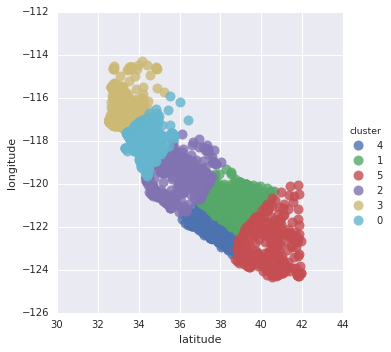

In [48]:
%matplotlib inline
sns.lmplot('latitude', 'longitude', 
           data=pandaDF, 
           fit_reg=False, 
           hue="cluster",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.show()

In [49]:
## I scale the feature here, because if we scale before creating the vector we also scale the categorical 'cluster' feature

from sklearn.preprocessing import StandardScaler

col_names = ["median_house_value_final", 
              "total_bedrooms", 
              "population", 
              "households", 
              "median_income", 
              "rooms_per_household"]

features = pandaDF[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [50]:
pandaDF[col_names] = features

In [51]:
dfP3 = sqlCtx.createDataFrame(pandaDF)

In [52]:
## indexes each cluster, a preprocessing step for one hot encoding.

from pyspark.ml.feature import StringIndexer

string_indexer = StringIndexer(inputCol='cluster', outputCol='indexed_cluster')
string_indexer_model = string_indexer.fit(dfP3)
df_stringindexer = string_indexer_model.transform(dfP3)
df_stringindexer.take(1)

[Row(median_house_value=452600.0, median_income=2.3447657583017163, housing_median_age=41.0, total_rooms=880.0, total_bedrooms=-0.9707061177799191, population=-0.9744285971768408, households=-0.9770328537634586, latitude=37.88, longitude=-122.23, median_house_value_final=2.129631481668038, rooms_per_household=0.6285594533305325, cluster=4, indexed_cluster=1.0)]

In [55]:
## one hot encoding the cluster variable so it can be used for linear regression

from pyspark.ml.feature import OneHotEncoder

onehotencoder = OneHotEncoder(inputCol='indexed_cluster', outputCol='onehotencoded_cluster')
df_onehotencoder = onehotencoder.transform(df_stringindexer)

In [56]:
dfsP3 = df_onehotencoder.select("median_house_value_final", 
              "total_bedrooms", 
              "population", 
              "households", 
              "median_income", 
              "rooms_per_household", "onehotencoded_cluster")

In [57]:
feature_columns = dfsP3.columns[1:7]

In [58]:
from pyspark.ml.feature import VectorAssembler
vectorassembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_features = vectorassembler.transform(dfsP3)
df_features.take(1)

[Row(median_house_value_final=2.129631481668038, total_bedrooms=-0.9707061177799191, population=-0.9744285971768408, households=-0.9770328537634586, median_income=2.3447657583017163, rooms_per_household=0.6285594533305325, onehotencoded_cluster=SparseVector(5, {1: 1.0}), features=DenseVector([-0.9707, -0.9744, -0.977, 2.3448, 0.6286, 0.0, 1.0, 0.0, 0.0, 0.0]))]

In [59]:
featuresAndLabel = df_features.select("median_house_value_final", "features")

In [60]:
input_dataP3 = featuresAndLabel.rdd.map(tuple)

In [61]:
input_dataP3.take(2)

[(2.129631481668038,
  DenseVector([-0.9707, -0.9744, -0.977, 2.3448, 0.6286, 0.0, 1.0, 0.0, 0.0, 0.0])),
 (1.3141561369243353,
  DenseVector([1.3486, 0.8614, 1.67, 2.3322, 0.327, 0.0, 1.0, 0.0, 0.0, 0.0]))]

In [62]:
df2P3 = sqlCtx.createDataFrame(input_dataP3, ["label", "features"])

In [63]:
trainingP3, testP3 = df2P3.randomSplit([.8,.2], seed = 314)

In [64]:
lrP3 = LinearRegression(labelCol="label", maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [65]:
modelP3 = lrP3.fit(trainingP3)

In [66]:
predictedP3 = modelP3.transform(testP3)

In [67]:
predAndLabP3 = predictedP3.rdd.map(lambda x:(x.prediction, x.label))

In [68]:
predAndLabP3.take(3)

[(-0.37328984794526077, -1.5595061831289252),
 (-0.6073305834988805, -1.507509880594789),
 (-0.6287166026385569, -1.4494473427650039)]

In [69]:
MSEP3 = predAndLabP3.map(lambda (pred, lab): (pred - lab)**2).reduce(lambda x, y: x + y) / predAndLabP3.count()

In [70]:
print("Mean Squared Error = " + str(MSEP3))

Mean Squared Error = 0.589122275747


In [4]:
out.iloc[1]['RMSE']= MSEP3
out

NameError: name 'MSEP3' is not defined